In [1]:
import sys
sys.path.insert(0, '/home/alapena/GitHub/graph2mat4abn')
import os
os.chdir('/home/ICN2/alapena/GitHub/graph2mat4abn') # Change to the root directory of the project

from graph2mat4abn.tools.import_utils import load_config, get_object_from_module
from graph2mat4abn.tools.tools import get_basis_from_structures_paths, get_kwargs, load_model
from graph2mat4abn.tools.scripts_utils import get_model_dataset, init_mace_g2m_model
from graph2mat4abn.tools.script_plots import update_loss_plots, plot_grad_norms
from pathlib import Path
from e3nn import o3
from mace.modules import MACE, RealAgnosticResidualInteractionBlock
from graph2mat.models import MatrixMACE
from graph2mat.bindings.e3nn import E3nnGraph2Mat
import torch
import warnings
from graph2mat import BasisTableWithEdges

warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support")
warnings.filterwarnings("ignore", message=".*is not a known matrix type key.*")

from joblib import dump, load
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sisl

FileNotFoundError: [Errno 2] No such file or directory: '/home/ICN2/alapena/GitHub/graph2mat4abn'

In [ ]:
# The current model:
model_dir = Path("results/h_noc_2")
filename = "train_best_model.tar"
config = load_config(model_dir / "config.yaml")

# Basis generation (needed to initialize the model)
train_paths, val_paths = get_model_dataset(model_dir, verbose=False)
paths = train_paths + val_paths
basis = get_basis_from_structures_paths(paths, verbose=True, num_unique_z=config["dataset"].get("num_unique_z", None))
table = BasisTableWithEdges(basis)

print("Initializing model...")
model, optimizer, lr_scheduler, loss_fn = init_mace_g2m_model(config, table)

# Load the model
model_path = model_dir / filename
model, checkpoint, optimizer, lr_scheduler = load_model(model, optimizer, model_path, lr_scheduler=None, initial_lr=None, device='cpu')
history = checkpoint["history"]
print(f"Loaded model in epoch {checkpoint["epoch"]} with training loss {checkpoint["train_loss"]} and validation loss {checkpoint["val_loss"]}.")

Basis computation.
Number of structures to look on: 629
Looking for unique atoms in each structure...


1it [00:00, 57.59it/s]

Found enough basis points. Breaking the search...
Found enough basis points. Breaking the search...
Found the following atomic numbers: [7, 5]
Corresponding path indices: [0, 0]
Basis with 2 elements built!

Basis for atom 0.
	Atom type: 5
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [3.02420918 2.02341372 3.73961942 3.73961942 3.73961942 2.51253945
 2.51253945 2.51253945 3.73961942 3.73961942 3.73961942 3.73961942
 3.73961942]

Basis for atom 1.
	Atom type: 7
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [2.25704422 1.4271749  2.78012609 2.78012609 2.78012609 1.75309697
 1.75309697 1.75309697 2.78012609 2.78012609 2.78012609 2.78012609
 2.78012609]
Initializing model...



/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/mace/modules/blocks.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(atomic_energies, dtype=torch.get_default_dtype()),


Using Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
LR Scheduler:  ReduceLROnPlateau
Arguments:  None
Keyword arguments:  {'cooldown': 0, 'eps': 0.0, 'factor': 0.1, 'min_lr': 0.0, 'mode': 'min', 'patience': 20}
Using Loss function <class 'graph2mat.core.data.metrics.block_type_mse'>
Loaded model in epoch 24782 with training loss 11333.201171875 and validation loss 35070.49609375.


In [ ]:
# === Inference ===
path = Path("dataset/SHARE_OUTPUTS_64_ATOMS/9410-b52a-4124-9c9c-210304f661a1")

from torch_geometric.data import DataLoader
from graph2mat4abn.tools.scripts_utils import generate_g2m_dataset_from_paths

dataset, processor = generate_g2m_dataset_from_paths(config, basis, table, [path], verbose=False)
dataloader = DataLoader(dataset, 1)
model.eval()

data = next(iter(dataloader))

with torch.no_grad():
    model_predictions = model(data=data)

    h_pred = processor.matrix_from_data(data, predictions={"node_labels": model_predictions["node_labels"], "edge_labels": model_predictions["edge_labels"]})[0]
    h_true = processor.matrix_from_data(data)[0]

1it [00:00,  2.33it/s]


Keeping all the dataset in memory.


/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


/tmp/ipykernel_580032/1073472128.py:10: RuntimeWarning: invalid value encountered in divide
  relative_error_matrix = np.where(mask, absolute_error_matrix / (true_matrix) * 100, 0)


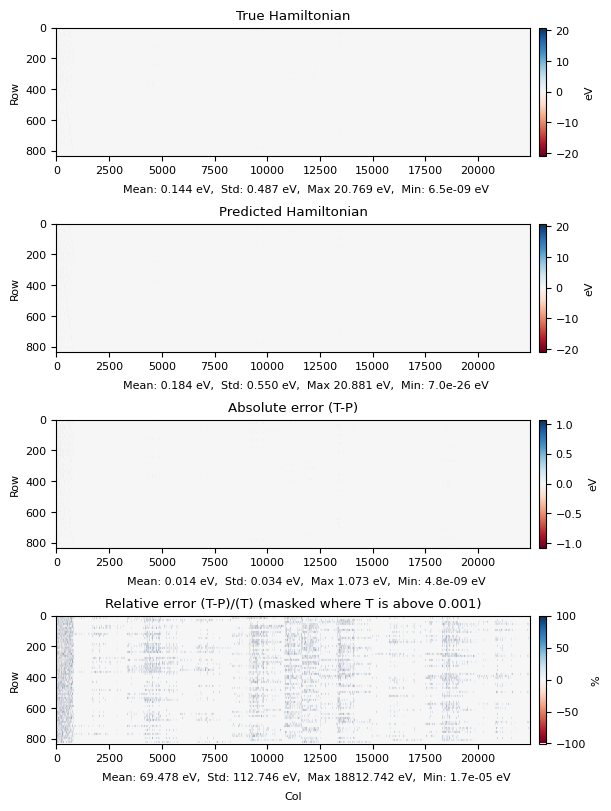

In [ ]:
# Plot hamiltonian

def plot_hamiltonian_matplotlib(true_matrix, predicted_matrix, matrix_label=None, figure_title=None, predicted_matrix_text=None, filepath=None, force_max_colorbar_abs_error=None, only_first_uc=False):
    """Matplotlib visualization of error matrices."""

    if only_first_uc:
        n_orbs = true_matrix.shape[0]
        true_matrix = true_matrix[:, :n_orbs]
        predicted_matrix = predicted_matrix[:, :n_orbs]
        figsize=(2, 8)
    else:
        figsize=(6, 8)

    # Error matrices
    absolute_error_matrix = true_matrix - predicted_matrix
    threshold = 0.001
    mask = true_matrix >= threshold
    relative_error_matrix = np.where(mask, absolute_error_matrix / (true_matrix) * 100, 0)

    # Colorbar limits
    vmin = np.min([np.min(true_matrix), np.min(predicted_matrix)])
    vmax = np.max([np.max(true_matrix), np.max(predicted_matrix)])
    lim_data = max(np.abs(vmin), np.abs(vmax))

    if force_max_colorbar_abs_error is None:
        lim_abs = np.max(np.abs(absolute_error_matrix))
    else:
        lim_abs = force_max_colorbar_abs_error

    lim_rel = 100.0  # %

    cbar_limits = [lim_data, lim_data, lim_abs, lim_rel]

    # Titles
    if matrix_label is None:
        matrix_label = ''
    titles = [
        "True " + matrix_label,
        "Predicted " + matrix_label,
        "Absolute error (T-P)",
        f"Relative error (T-P)/(T) (masked where T is above {threshold})"
    ]
    cbar_titles = ["eV", "eV", "eV", "%"]

    # Matrices to plot
    matrices = [true_matrix, predicted_matrix, absolute_error_matrix, relative_error_matrix]

    fig, axes = plt.subplots(4, 1, figsize=figsize, constrained_layout=True, gridspec_kw={'hspace': 0.15})
    # fig.suptitle(figure_title if figure_title else "Matrix Comparison and Errors", fontsize=16)

    for i, (matrix, ax) in enumerate(zip(matrices, axes)):
        im = ax.imshow(matrix, cmap='RdBu', vmin=-cbar_limits[i], vmax=cbar_limits[i])
        ax.set_title(titles[i])
        ax.set_ylabel("Row")
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.045, pad=0.02)
        cbar.set_label(cbar_titles[i])
        if i==3:
            ax.set_xlabel("Col", labelpad=20)
        ax.set_aspect('auto')
        

    y_offset = 0.035
    addition = 0.245
    # True matrix stats (exclude zeros for stats)
    matrix_nnz = np.abs(true_matrix)[true_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 3*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Predicted stats
    matrix_nnz = np.abs(predicted_matrix)[predicted_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 2*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Absolute error stats (exclude zeros for stats)
    matrix_nnz = np.abs(absolute_error_matrix)[absolute_error_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 1*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Relative error stats (exclude zeros for stats)
    matrix_nnz = np.abs(relative_error_matrix)[relative_error_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 0*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # axes[-1].set_xlabel(" ")

    # Output
    if filepath:
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close(fig)
    return fig

fig = plot_hamiltonian_matplotlib(true_matrix=h_true.todense(), predicted_matrix=h_pred.todense(), matrix_label="Hamiltonian")
fig.show()

In [ ]:
# Plot only the zero shift

fig = plot_hamiltonian_matplotlib(true_matrix=h_true.todense(), predicted_matrix=h_pred.todense(), matrix_label="Hamiltonian", only_first_uc=True)
fig.show()

In [ ]:
file = sisl.get_sile(path / "aiida.fdf")
fig = file.plot.geometry(axes="xyz")
fig.show()

# Fermi Energy

In [ ]:
import numpy as np
import tbplas as tb
import sisl
from pathlib import Path

def add_orbitals(cell: tb.PrimitiveCell, positions, onsites, labels) -> None:
    """
    Add orbitals to the model.

    There are n_atoms atoms, with n_orbs orbitals each in that same position. We will extract those orbitals from the atom info.
    """
    for i in range(positions.shape[0]):
        n_orbs = len(labels[i])
        for j in range(n_orbs):
            cell.add_orbital_cart(positions[i], unit=tb.ANG, energy=onsites[i*n_orbs+j], label=labels[i][j])


def add_hopping_terms(cell: tb.PrimitiveCell, iscs, orbs_in, orbs_out, hoppings) -> None:
    n_hops = len(iscs)
    for i in range(n_hops):
        cell.add_hopping(rn=iscs[i], orb_i=orbs_in[i], orb_j=orbs_out[i], energy=hoppings[i])


def real_space_to_kspace(positions, b1, b2, b3):
    """
    Map real-space positions into reciprocal space (fractional and cartesian).
    Returns:
        k_frac: (N, 3) positions in fractional reciprocal coordinates
        k_cart: (N, 3) positions in cartesian k-space (nm^-1)
    """
    B = np.vstack([b1, b2, b3])  # reciprocal lattice vectors (3,3), Ang^-1
    # Fractional reciprocal coordinates
    k_frac = np.linalg.solve(B.T, positions.T).T  # shape (N,3)
    # Cartesian k-vectors
    k_cart = k_frac @ B
    return k_frac, k_cart

In [ ]:
file = sisl.get_sile(path / "aiida.HSX")
geometry = file.read_geometry()

vectors = geometry.cell
cell = tb.PrimitiveCell(vectors, unit=tb.ANG)

# Add orbitals
positions = geometry.xyz #Angstrom
labels = [[orb.name() for orb in atom] for atom in geometry.atoms]

# To add the orbitals we need the onsite energies.
h = file.read_hamiltonian()
h_mat = h.tocsr().tocoo()

rows = h_mat.row
cols = h_mat.col
data = h_mat.data

# Main diagonal length:
n_diag = min(h_mat.shape[0], h_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# onsites = 
add_orbitals(cell, positions, onsites, labels)


# Add hopping terms.
# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = int(path.parts[-2].split("_")[-2])
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
    

add_hopping_terms(cell, iscs, orbs_in, orbs_out, hoppings)



# Get overlap

# To add the orbitals we need the onsite energies.
o = file.read_overlap()
o_mat = o.tocsr().tocoo()

rows = o_mat.row
cols = o_mat.col
data = o_mat.data

# Main diagonal length:
n_diag = min(o_mat.shape[0], o_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# Add onsites to overlap
overlap = tb.PrimitiveCell(cell.lat_vec, cell.origin, 1.0)
for i in range(cell.num_orb):
    orbital = cell.orbitals[i]
    overlap.add_orbital(orbital.position, onsites[i])


# Add hopping terms to overlap

# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = int(path.parts[-2].split("_")[-2])
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
        

add_hopping_terms(overlap, iscs, orbs_in, orbs_out, hoppings)

In [ ]:
# Define a path in k-space

b1, b2, b3 = cell.get_reciprocal_vectors()/10 # Angstrom^-1
k_pos_frac, k_pos_cart = real_space_to_kspace(positions, b1, b2, b3)

# Compute k path
B = np.vstack([b1, b2, b3])  # shape (3,3)
k_cart = np.array([[0.0, 0.0, 0.0], b3/2, b3])
k_label = ['Γ', "Z/2", "Z"]

k_frac = np.array([np.linalg.solve(B.T, k) for k in k_cart])

n_ks = 200
k_path, k_idx = tb.gen_kpath(k_frac, [n_ks for _ in range(len(k_frac) -1)])
len(k_path)

In [ ]:
solver = tb.DiagSolver(cell, overlap)
solver.config.k_points = k_path
solver.config.prefix = "Test"

timer = tb.Timer()
timer.tic("bands")
k_len, bands = solver.calc_bands()
timer.toc("bands")

vis = tb.Visualizer()
timer.report_total_time()
fig_bands = vis.plot_bands(k_len, bands, k_idx, k_label)

In [ ]:
# DOS
# n_ks=20
# k_mesh = tb.gen_kmesh((n_ks, n_ks, n_ks))  # Uniform meshgrid
# e_min = float(np.min(bands))
# e_max = float(np.max(bands))

# solver = tb.DiagSolver(cell, overlap)
# solver.config.k_points = k_mesh
# # solver.config.prefix = "graphene"
# solver.config.e_min = e_min - 10
# solver.config.e_max = e_max + 10
# timer = tb.Timer()
# timer.tic("dos")
# energies, dos = solver.calc_dos()
# timer.toc("dos")

# Instead, load previously computed results.


vis = tb.Visualizer()
fig_dos = vis.plot_dos(energies, dos)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re

def read_fermi_level(path: str) -> float:
    """
    Return the last reported Fermi level (in eV) from a SIESTA aiida.out file.
    """
    pat = re.compile(r'Fermi\s*=\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)')
    fermi = None
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = pat.search(line)
            if m:
                fermi = float(m.group(1))
    if fermi is None:
        raise ValueError("Fermi level not found in file.")
    return fermi

def plot_bands_matplotlib(k_len, bands, k_idx, k_label,
                          predicted_bands=None, filepath=None,
                          ylim=None, fermi_lvl=None, legend_loc=None):
    k_len = np.asarray(k_len)
    bands = np.asarray(bands)
    assert bands.ndim == 2, "bands must be (n_kpoints, n_bands)"

    fig, ax = plt.subplots(figsize=(4, 5), facecolor="white")
    ax.set_facecolor("white")

    # True bands: label only on the first column
    ax.plot(k_len, bands[:, 0], color="red", lw=2, label="True bands")
    ax.plot(k_len, bands[:, 1:], color="red", lw=2)  # no label

    # Predicted bands
    if predicted_bands is not None:
        predicted_bands = np.asarray(predicted_bands)
        assert predicted_bands.shape == bands.shape
        ax.plot(k_len, predicted_bands[:, 0], color="red", lw=2, ls="--", label="Predicted bands")
        ax.plot(k_len, predicted_bands[:, 1:], color="red", lw=2, ls="--")  # no label

    # Decide vertical line span
    if ylim is not None:
        vmin, vmax = ylim
    else:
        vmin = np.nanmin(bands if predicted_bands is None else np.dstack((bands, predicted_bands)))
        vmax = np.nanmax(bands if predicted_bands is None else np.dstack((bands, predicted_bands)))

    # Vertical separators
    ax.vlines(k_len[np.asarray(k_idx, int)], vmin, vmax, colors="black", lw=2)

    # Optional Fermi level
    if fermi_lvl is not None:
        ax.axhline(fermi_lvl, color="grey", ls="--", lw=2, label="Fermi level")

    # Axes & ticks
    ax.set_xlabel(r"$k$ ($1/\AA$)")
    ax.set_ylabel("Energy (eV)")
    ax.set_xlim(k_len.min(), k_len.max())
    ax.set_xticks(k_len[np.asarray(k_idx, int)])
    ax.set_xticklabels(k_label)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Styling
    ax.tick_params(direction="out")
    for s in ax.spines.values():
        s.set_color("black")

    if legend_loc is None:
        legend_loc = "best"
    ax.legend(loc=legend_loc)
    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")
    else:
        plt.show()

    return fig, ax

k_len_plot = np.repeat(k_len[:,None], bands.shape[0], axis=1)
fermi_lvl=read_fermi_level(path / "aiida.out")
print("Fermi level:", fermi_lvl)

# fig_bands = plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None)
fig_bands = plot_bands_matplotlib(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None, ylim = [-10, 10], fermi_lvl=fermi_lvl, legend_loc="upper right")